### I downloaded and embedded all the TED PDZ annotated domains (4,015) from the AFDB clustered representatives.
### Now I want to see what a PCA of these domains looks like and see if there are clusters that reflect the three topologies I identified and potentially other topologies as well.

### Let's use TM-align -CP to find the best topology match for each TED PDZ domain

In [ ]:
import os

In [ ]:
def tmscore(q,t, cp=False):
    ''' Run TM-align and get back TM-align score '''
    if cp:
        output = os.popen(f'/home/gridsan/akolodziej/TM_tools/TMalign {q} {t} -cp')
    else:
        output = os.popen(f'/home/gridsan/akolodziej/TM_tools/TMalign {q} {t}')
    tms = {"tms":[]}
    parse_float = lambda x: float(x.split("=")[1].split()[0])
    # print(output, flush=True)
    # print(q)
    # print(t)
    # print(f'{os.path.exists(q)}')
    # print(f'{os.path.exists(t)}')
    for line in output:
        line = line.rstrip()
        if line.startswith("TM-score"): 
            tms["tms"].append(parse_float(line))
    #error handling, set tm scor eto 0 for now. 
    if tms['tms']:
        min_tms = min(tms['tms'])
    else:
        print(f"Warning: tms['tms'] is empty, setting min_tms to 0 for {q}, {t}")
        min_tms = 0
    return min_tms

### Dictionary of PDZ topologies 'gems'

In [ ]:
pdz_gems = {'h': '/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/PDZ_topos/2hga_PDZ.pdb',
'v': '/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/PDZ_topos/2vsv_PDZ.pdb',
'z': '/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/PDZ_topos/2z9i_PDZ.pdb',
's': '/home/gridsan/akolodziej/TED/PDB_spotcheck/AF-A0A7S0ZYL0-F1-model_v4_TED01.pdb'}

In [ ]:
pdz_gems

### Create dictionary of TED PDZ domain names and their highest ranked topology

### Function to get PDZ topo

In [ ]:
def check_close_matches(scores, threshold=0.025):
    """
    Check if any values in the dictionary are within threshold of each other.
    If yes, return 'no match', otherwise return None.
    
    Args:
        scores: dict of scores
        threshold: float, maximum difference to consider values too close
    
    Returns:
        str: 'no match' if any values are too close, None otherwise
    """
    values = list(scores.values())
    
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            if abs(values[i] - values[j]) <= threshold:
                return 'no match'
    
    return None

In [ ]:
def get_pdz_topo(domain_path, pdz_gems, tm_threshold = 0.1):
    ''' Retrieve highest PDZ topology match to the input domain, if highest topology is below 0.7 TM-score, report no good match '''
    top_tm_score = 0
    topology = ''
    
    topo_tm = {}
    
    for topo in list(pdz_gems.keys()):
        topo_pdb = pdz_gems[topo]
        
        # CP set to False! Important! 
        score = tmscore(domain_path, topo_pdb, cp =False)
        
        topo_tm[topo] = score
        
        if score > top_tm_score:
            top_tm_score = score
            topology = topo
            #print(score)
            #print(topology)
            
    result = check_close_matches(topo_tm)
    if result == 'no match':
        topology = 'no match'
    
    return topology, topo_tm

In [ ]:
test_p= '/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/PDZ_pdbs/PDZ_ted_pdbs/AF-A0A2S2R9N2-F1-model_v4_TED01.pdb'
a = get_pdz_topo(test_p, pdz_gems)
a

### Quality check: only look at PDZ domains that are 75-100 AA (others are likely not high quality PDZ domains)

In [12]:
def get_pdb_length(pdb_path):
    ''' Returns the length of a pdb '''
    with open(pdb_path, 'r') as f:
        length = sum(1 for line in f if line.startswith('ATOM') and ' CA ' in line)
    #print(f"Length: {length} residues")
    
    return length

### Make list of pdb domains that are 75-100 AA

In [ ]:
pdz_pdb_dir = '/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/PDZ_pdbs/PDZ_ted_pdbs'
pdz_domains = [f for f in os.listdir(pdz_pdb_dir) if f.endswith('.pdb')]

### Make a list of PDZ domains that are 75-100 AA
pdz_domains_hq = []

for i, domain in enumerate(pdz_domains):
    path = os.path.join(pdz_pdb_dir,domain)
    pdb_len = get_pdb_length(path)
    if pdb_len > 75 and pdb_len < 100:
        pdz_domains_hq.append(domain)
    if i % 100 == 0:
        print(i)

## Get length of all the ~4K PDZ and plot distribution of the lengths

In [15]:
pdz_pdb_dir = '/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/PDZ_pdbs/PDZ_ted_pdbs'
pdz_domains = [f for f in os.listdir(pdz_pdb_dir) if f.endswith('.pdb')]

### Make a list of PDZ domains that are 75-100 AA
pdz_domain_lengths = []

for i, domain in enumerate(pdz_domains):
    path = os.path.join(pdz_pdb_dir,domain)
    pdb_len = get_pdb_length(path)
    pdz_domain_lengths.append(pdb_len)
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


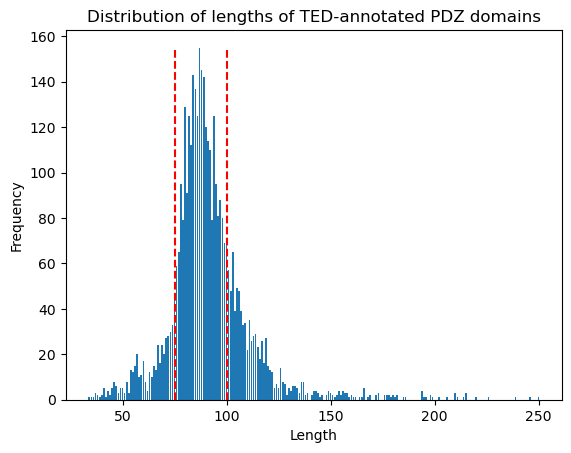

In [21]:
freq = {x: pdz_domain_lengths.count(x) for x in set(pdz_domain_lengths)}
import matplotlib.pyplot as plt
plt.bar(freq.keys(), freq.values())
plt.vlines([75, 100], ymin=0, ymax=max(freq.values()), linestyles='dashed', color= 'red')

plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Distribution of lengths of TED-annotated PDZ domains")
plt.show()

In [ ]:
import pickle
pdz_length_hq_path = '/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/PDZ_pdbs/PDZ_ted_pdbs/PDZ_length_hq.pkl'

with open(pdz_length_hq_path, 'wb') as f:
    pickle.dump(pdz_domains_hq, f)

### Went from 4015 to 2563 PDZ domains after accounting for accurate length

In [ ]:
len(pdz_domains_hq)

In [ ]:
test_p= '/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/PDZ_pdbs/PDZ_ted_pdbs/AF-A0A2S2R9N2-F1-model_v4_TED01.pdb'
a = get_pdz_topo(test_p, pdz_gems)
a

### Make dictionary of PDZ_topos

In [ ]:
pdz_topos = {domain: '' for domain in pdz_domains_hq} 


In [ ]:
for i, domain in enumerate(list(pdz_topos.keys())):
    #print(domain)
    path = os.path.join(pdz_pdb_dir,domain)
    #print(os.path.exists(path))
    #print(path)
    topo = get_pdz_topo(path,pdz_gems)
    #print(topo)
    pdz_topos[domain] = [topo]
    if i % 100 == 0:
        print(f'Processed {i}')

### Get list for each topology

In [ ]:
h_topos = []
v_topos = []
z_topos = []
s_topos = []
no_match_topos = []
for d in list(pdz_topos.keys()):
    if pdz_topos[d][0][0] == 'h':
        #print('h')
        h_topos.append(d)
    elif pdz_topos[d][0][0] == 'v':
        #print('v')
        v_topos.append(d)
    elif pdz_topos[d][0][0] == 'z':
        #print('z')
        z_topos.append(d)
    elif pdz_topos[d][0][0] == 's':
        #print('z')
        s_topos.append(d)
    elif pdz_topos[d][0][0] == 'no match':
        #print('z')
        no_match_topos.append(d)

In [ ]:
len(pdz_topos)

### Save full dictionary of PDZs with their topology and TM align score to each topology

In [ ]:
import pickle
with open('AFDB_TED_PDZ_topo_dictionary_h_v_z_s_no_match_diff_025.pkl', 'wb') as f:
    pickle.dump(pdz_topos, f)

print("Dictionary saved!")

In [1]:
import pickle
with open('AFDB_TED_PDZ_topo_dictionary_h_v_z_s_no_match_diff_025.pkl', 'rb') as f:
    pdz_topos = pickle.load(f)

### Plot PCA of PDZ embeddings and color by their topology

In [2]:
pdz_topos_best = {}

In [3]:
for domain in list(pdz_topos.keys()):
    pdz_topos_best[domain] = pdz_topos[domain][0][0]

### Get the embedding of a domain

In [4]:
progres_embs_dir = '/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/embs_Progres_single'
cirpin_embs_dir = '/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/embs_CIRPIN_single'

In [6]:
pdz_topos_best

{'AF-A0A7S0HAE2-F1-model_v4_TED01.pdb': 'no match',
 'AF-A0A1V9YBY8-F1-model_v4_TED02.pdb': 'v',
 'AF-F0W5J2-F1-model_v4_TED05.pdb': 'v',
 'AF-A0A673GIU9-F1-model_v4_TED03.pdb': 'v',
 'AF-A0A1V5D6X6-F1-model_v4_TED02.pdb': 'no match',
 'AF-A0A0L0G8Z2-F1-model_v4_TED01.pdb': 'v',
 'AF-A0A1V9ZY34-F1-model_v4_TED02.pdb': 'v',
 'AF-A0A369RUT6-F1-model_v4_TED04.pdb': 'no match',
 'AF-A0A2P2K550-F1-model_v4_TED01.pdb': 'no match',
 'AF-A0A3P4RSQ7-F1-model_v4_TED02.pdb': 'v',
 'AF-A0A7S1ALP6-F1-model_v4_TED01.pdb': 's',
 'AF-M9PC26-F1-model_v4_TED02.pdb': 'v',
 'AF-A0A7V9IKR0-F1-model_v4_TED03.pdb': 'z',
 'AF-A0A2K2ZDJ6-F1-model_v4_TED03.pdb': 'no match',
 'AF-A0A5C6PB22-F1-model_v4_TED02.pdb': 'v',
 'AF-A0A4V1ZLR1-F1-model_v4_TED01.pdb': 'z',
 'AF-A0A1M5Y960-F1-model_v4_TED02.pdb': 'no match',
 'AF-A0A0J7P0B0-F1-model_v4_TED02.pdb': 'no match',
 'AF-A0A7C1DX13-F1-model_v4_TED01.pdb': 'z',
 'AF-A0A3P7P024-F1-model_v4_TED01.pdb': 'no match',
 'AF-A0A815VPV3-F1-model_v4_TED05.pdb': 'v',
 'AF-A0

In [7]:
pdz_topos['AF-A0A7C2S6A7-F1-model_v4_TED02.pdb']

[('h', {'h': 0.61678, 'v': 0.48572, 'z': 0.59074, 's': 0.43565})]

In [8]:
len(pdz_topos)

2563

In [9]:
import torch
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


Total embeddings loaded: (2563, 128)


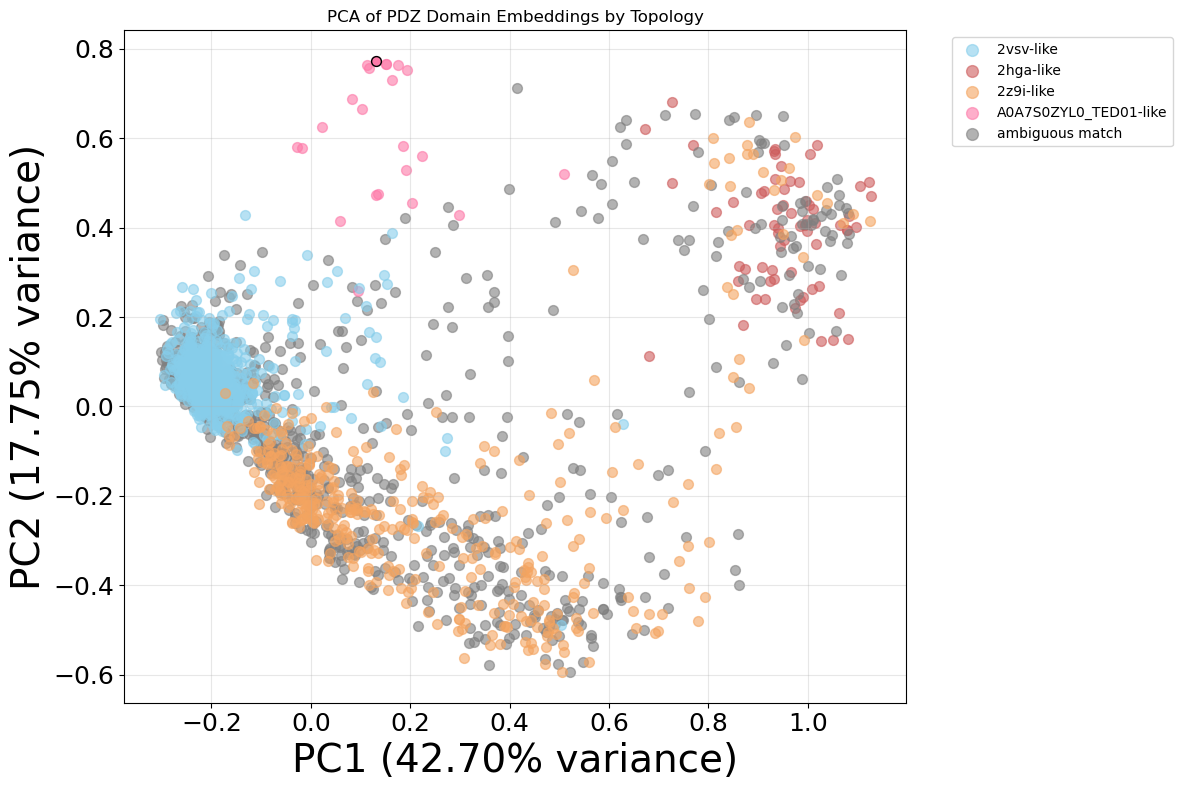


Explained variance: PC1=42.70%, PC2=17.75%

5 closest neighbors to AF-A0A7S0ZYL0-F1-model_v4_TED01.pdb:
--------------------------------------------------------------------------------


IndexError: list index out of range

In [10]:
# Load all embeddings
embeddings = []
domain_names = []
labels = []
for domain in list(pdz_topos_best.keys()):
    domain_pt = domain.split('.')[0] + ".pt"
    pdb_path = os.path.join(progres_embs_dir, domain_pt)
    
    try:
        emb = torch.load(pdb_path)
        emb_np = emb.cpu().numpy() if emb.is_cuda else emb.numpy()
        
        embeddings.append(emb_np)
        domain_names.append(domain)
        labels.append(pdz_topos_best[domain])
        #print(f"Loaded {domain}: shape {emb_np.shape}, label: {pdz_topos_best[domain]}")
    except Exception as e:
        print(f"Error loading {domain}: {e}")

# Convert to numpy array
embeddings = np.array(embeddings)
print(f"\nTotal embeddings loaded: {embeddings.shape}")

# Run PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))  # Increased width to accommodate external legend

# Specify domain to highlight
highlight_domain = 'AF-A0A7S0ZYL0-F1-model_v4_TED01.pdb'

# Create custom color map for labels
label_to_color = {
    'v': '#87CEEB',  # light blue
    'h': '#CD5C5C',  # reddish (indian red)
    'z': '#F4A460',
    's': '#fd79a8',
    'no match': 'grey'  # sand (sandy brown)
}

label_to_stru = {
    'h': '2hga-like',
    'v': '2vsv-like',
    'z': '2z9i-like',
    's': 'A0A7S0ZYL0_TED01-like',
    'no match': 'ambiguous match'
}

# Plot each topology type
unique_labels = sorted(set(labels))
for label in unique_labels:
    mask = np.array(labels) == label
    plt.scatter(embeddings_pca[mask, 0], embeddings_pca[mask, 1], 
                label=f'{label_to_stru[label]}', alpha=0.6, s=50, 
                color=label_to_color[label])

# Highlight specific domain in bright yellow
if highlight_domain in domain_names:
    idx = domain_names.index(highlight_domain)
    plt.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1], 
                color='#fd79a8', s=50, edgecolors='black', linewidths=1,
                label=f'A0A7S0ZYL0_TED01', zorder=5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize =28)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize =28)
plt.title('PCA of PDZ Domain Embeddings by Topology')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


# Define the order you want
desired_order = ['2vsv-like', '2hga-like', '2z9i-like', 'A0A7S0ZYL0_TED01-like', 'ambiguous match']

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder them
ordered_handles = []
ordered_labels = []
for label in desired_order:
    if label in labels:
        idx = labels.index(label)
        ordered_handles.append(handles[idx])
        ordered_labels.append(labels[idx])

plt.legend(ordered_handles, ordered_labels, fontsize=10, markerscale=1.2, 
           bbox_to_anchor=(1.05, 1), loc='upper left')

# Legend outside the plot area
#plt.legend(fontsize=10, markerscale=1.2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/pca_embeddings_Progres.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nExplained variance: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}")

# Find neighbors of highlighted domain
if highlight_domain in domain_names:
    idx = domain_names.index(highlight_domain)
    
    # Calculate distances in PCA space
    distances = np.sqrt(np.sum((embeddings_pca - embeddings_pca[idx])**2, axis=1))
    
    # Get indices sorted by distance (excluding the domain itself)
    sorted_indices = np.argsort(distances)[1:]  # Skip index 0 (itself)
    
    # Get top N closest neighbors
    n_neighbors = 5
    print(f"\n{n_neighbors} closest neighbors to {highlight_domain}:")
    print("-" * 80)
    for i, neighbor_idx in enumerate(sorted_indices[:n_neighbors]):
        neighbor_name = domain_names[neighbor_idx]
        neighbor_label = labels[neighbor_idx]
        dist = distances[neighbor_idx]
        print(f"{i+1}. {neighbor_name}")
        print(f"   Topology: {neighbor_label}, Distance: {dist:.4f}")
        print()

In [ ]:
import torch
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


Total embeddings loaded: (2563, 128)


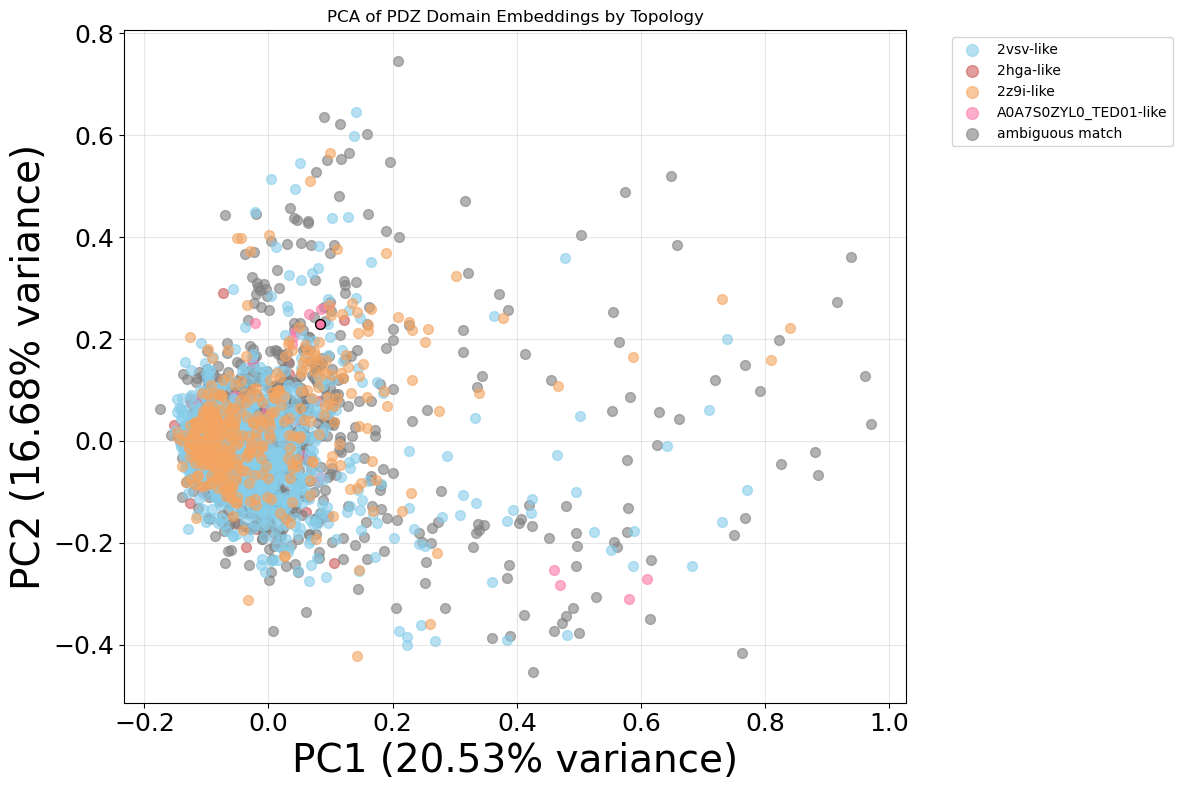


Explained variance: PC1=20.53%, PC2=16.68%

5 closest neighbors to AF-A0A7S0ZYL0-F1-model_v4_TED01.pdb:
--------------------------------------------------------------------------------


IndexError: list index out of range

In [9]:
# Load all embeddings
embeddings = []
domain_names = []
labels = []
for domain in list(pdz_topos_best.keys()):
    domain_pt = domain.split('.')[0] + ".pt"
    pdb_path = os.path.join(cirpin_embs_dir, domain_pt)
    
    try:
        emb = torch.load(pdb_path)
        emb_np = emb.cpu().numpy() if emb.is_cuda else emb.numpy()
        
        embeddings.append(emb_np)
        domain_names.append(domain)
        labels.append(pdz_topos_best[domain])
        #print(f"Loaded {domain}: shape {emb_np.shape}, label: {pdz_topos_best[domain]}")
    except Exception as e:
        print(f"Error loading {domain}: {e}")

# Convert to numpy array
embeddings = np.array(embeddings)
print(f"\nTotal embeddings loaded: {embeddings.shape}")

# Run PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))  # Increased width to accommodate external legend

# Specify domain to highlight
highlight_domain = 'AF-A0A7S0ZYL0-F1-model_v4_TED01.pdb'

# Create custom color map for labels
label_to_color = {
    'v': '#87CEEB',  # light blue
    'h': '#CD5C5C',  # reddish (indian red)
    'z': '#F4A460',
    's': '#fd79a8',
    'no match': 'grey'  # sand (sandy brown)
}

label_to_stru = {
    'h': '2hga-like',
    'v': '2vsv-like',
    'z': '2z9i-like',
    's': 'A0A7S0ZYL0_TED01-like',
    'no match': 'ambiguous match'
}

# Plot each topology type
unique_labels = sorted(set(labels))
for label in unique_labels:
    mask = np.array(labels) == label
    plt.scatter(embeddings_pca[mask, 0], embeddings_pca[mask, 1], 
                label=f'{label_to_stru[label]}', alpha=0.6, s=50, 
                color=label_to_color[label])

# Highlight specific domain in bright yellow
if highlight_domain in domain_names:
    idx = domain_names.index(highlight_domain)
    plt.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1], 
                color='#fd79a8', s=50, edgecolors='black', linewidths=1,
                label=f'A0A7S0ZYL0_TED01', zorder=5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize =28)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize =28)
plt.title('PCA of PDZ Domain Embeddings by Topology')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Define the order you want
desired_order = ['2vsv-like', '2hga-like', '2z9i-like', 'A0A7S0ZYL0_TED01-like', 'ambiguous match']

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder them
ordered_handles = []
ordered_labels = []
for label in desired_order:
    if label in labels:
        idx = labels.index(label)
        ordered_handles.append(handles[idx])
        ordered_labels.append(labels[idx])

plt.legend(ordered_handles, ordered_labels, fontsize=10, markerscale=1.2, 
           bbox_to_anchor=(1.05, 1), loc='upper left')

# Legend outside the plot area
#plt.legend(fontsize=10, markerscale=1.2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/gridsan/akolodziej/TED/ted_365_chunks/AFDB_PDZ/pca_embeddings_cirpin.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nExplained variance: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}")

# Find neighbors of highlighted domain
if highlight_domain in domain_names:
    idx = domain_names.index(highlight_domain)
    
    # Calculate distances in PCA space
    distances = np.sqrt(np.sum((embeddings_pca - embeddings_pca[idx])**2, axis=1))
    
    # Get indices sorted by distance (excluding the domain itself)
    sorted_indices = np.argsort(distances)[1:]  # Skip index 0 (itself)
    
    # Get top N closest neighbors
    n_neighbors = 5
    print(f"\n{n_neighbors} closest neighbors to {highlight_domain}:")
    print("-" * 80)
    for i, neighbor_idx in enumerate(sorted_indices[:n_neighbors]):
        neighbor_name = domain_names[neighbor_idx]
        neighbor_label = labels[neighbor_idx]
        dist = distances[neighbor_idx]
        print(f"{i+1}. {neighbor_name}")
        print(f"   Topology: {neighbor_label}, Distance: {dist:.4f}")
        print()

In [ ]:
import torch
import os
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

# Load all embeddings
embeddings = []
domain_names = []
labels = []

for domain in list(pdz_topos_best.keys()):
    domain_pt = domain.split('.')[0] + ".pt"
    pdb_path = os.path.join(progres_embs_dir, domain_pt)
    
    try:
        emb = torch.load(pdb_path)
        emb_np = emb.cpu().numpy() if emb.is_cuda else emb.numpy()
        
        embeddings.append(emb_np)
        domain_names.append(domain)
        labels.append(pdz_topos_best[domain])
    except Exception as e:
        print(f"Error loading {domain}: {e}")

# Convert to numpy array
embeddings = np.array(embeddings)
print(f"Total embeddings loaded: {embeddings.shape}")

# Run PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Create DataFrame (tidyverse style!)
df = pd.DataFrame({
    'PC1': embeddings_pca[:, 0],
    'PC2': embeddings_pca[:, 1],
    'topology': labels,
    'domain': domain_names
})

# Specify domain to highlight
highlight_domain = 'AF-A0A7S2D402-F1-model_v4_TED02.pdb'
df['highlight'] = df['domain'].apply(lambda x: 'Highlighted' if x == highlight_domain else 'Normal')

# Custom colors
color_map = {
    'v': '#87CEEB',  # light blue
    'h': '#CD5C5C',  # reddish
    'z': '#F4A460'   # sand
}

# Plot with plotly
fig = px.scatter(df, x='PC1', y='PC2', color='topology',
                 color_discrete_map=color_map,
                 hover_data=['domain'],
                 labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
                         'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)'},
                 title='PCA of PDZ Domain Embeddings by Topology')

# Add highlighted point
if highlight_domain in domain_names:
    highlight_df = df[df['domain'] == highlight_domain]
    fig.add_scatter(x=highlight_df['PC1'], y=highlight_df['PC2'],
                    mode='markers',
                    marker=dict(size=15, color='#FFFF00', 
                               line=dict(width=2, color='black')),
                    name='Highlighted',
                    showlegend=True)

fig.update_layout(width=900, height=700)
fig.show()

# Find neighbors
if highlight_domain in domain_names:
    idx = df[df['domain'] == highlight_domain].index[0]
    distances = np.sqrt((df['PC1'] - df.loc[idx, 'PC1'])**2 + 
                       (df['PC2'] - df.loc[idx, 'PC2'])**2)
    df['distance'] = distances
    
    neighbors = df[df['domain'] != highlight_domain].nsmallest(5, 'distance')
    print(f"\n5 closest neighbors to {highlight_domain}:")
    print("-" * 80)
    for i, row in enumerate(neighbors.itertuples(), 1):
        print(f"{i}. {row.domain}")
        print(f"   Topology: {row.topology}, Distance: {row.distance:.4f}\n")

print(f"\nExplained variance: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}")

In [ ]:
import torch
import os
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

# Load all embeddings
embeddings = []
domain_names = []
labels = []

for domain in list(pdz_topos_best.keys()):
    domain_pt = domain.split('.')[0] + ".pt"
    pdb_path = os.path.join(cirpin_embs_dir, domain_pt)
    
    try:
        emb = torch.load(pdb_path)
        emb_np = emb.cpu().numpy() if emb.is_cuda else emb.numpy()
        
        embeddings.append(emb_np)
        domain_names.append(domain)
        labels.append(pdz_topos_best[domain])
    except Exception as e:
        print(f"Error loading {domain}: {e}")

# Convert to numpy array
embeddings = np.array(embeddings)
print(f"Total embeddings loaded: {embeddings.shape}")

# Run PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Create DataFrame (tidyverse style!)
df = pd.DataFrame({
    'PC1': embeddings_pca[:, 0],
    'PC2': embeddings_pca[:, 1],
    'topology': labels,
    'domain': domain_names
})

# Specify domain to highlight
highlight_domain = 'AF-A0A7S4IEI6-F1-model_v4_TED01.pdb'
df['highlight'] = df['domain'].apply(lambda x: 'Highlighted' if x == highlight_domain else 'Normal')

# Custom colors
color_map = {
    'v': '#87CEEB',  # light blue
    'h': '#CD5C5C',  # reddish
    'z': '#F4A460'   # sand
}

# Plot with plotly
fig = px.scatter(df, x='PC1', y='PC2', color='topology',
                 color_discrete_map=color_map,
                 hover_data=['domain'],
                 labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
                         'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)'},
                 title='PCA of PDZ Domain Embeddings by Topology')

# Add highlighted point
if highlight_domain in domain_names:
    highlight_df = df[df['domain'] == highlight_domain]
    fig.add_scatter(x=highlight_df['PC1'], y=highlight_df['PC2'],
                    mode='markers',
                    marker=dict(size=15, color='#FFFF00', 
                               line=dict(width=2, color='black')),
                    name='Highlighted',
                    showlegend=True)

fig.update_layout(width=900, height=700)
fig.show()

# Find neighbors
if highlight_domain in domain_names:
    idx = df[df['domain'] == highlight_domain].index[0]
    distances = np.sqrt((df['PC1'] - df.loc[idx, 'PC1'])**2 + 
                       (df['PC2'] - df.loc[idx, 'PC2'])**2)
    df['distance'] = distances
    
    neighbors = df[df['domain'] != highlight_domain].nsmallest(5, 'distance')
    print(f"\n5 closest neighbors to {highlight_domain}:")
    print("-" * 80)
    for i, row in enumerate(neighbors.itertuples(), 1):
        print(f"{i}. {row.domain}")
        print(f"   Topology: {row.topology}, Distance: {row.distance:.4f}\n")

print(f"\nExplained variance: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}")

In [ ]:
import torch
for domain in list(pdz_topos_best.keys()):
    domain_pt = domain.split('.')[0] + ".pt"
    pdb_path = os.path.join(progres_embs_dir, domain_pt)
    print(pdb_path)
    emb = torch.load(pdb_path)
    print(emb)
    break